In [1]:
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
import os

### Metropolisovým algoritmem simulujte soustavu 500 atomů argonu plynu při teplotě 170 K a číselné hustotě N/V = 0.14287 mol/dm3. 

### Argon modelujte mezičásticovým potenciálem Lannard-Jonese s parametry e = 119.8 kB, s = 0.341 nm. 

### Proveďte také plnou simulaci mikroskopických stavů ve fázovém prostoru (generujte polohy i hybnosti částic).

### Vypočtěte radiální distribuční funkci argonu za zmíněných podmínek a sestrojte její graf.

### $ r_{abs} = |\vec{r_{1}} - \vec{r_{2}}| = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2} $

In [ ]:
def vzdalenost_dvou_casic(poloha_castice_1, poloha_castice_2):
    summa = 0
    for souradnice_c1, souradnice_c2 in zip(poloha_castice_1, poloha_castice_2):
        delta = souradnice_c1 - souradnice_c2
        delta -= round(delta / velikost_strany_boxu) * velikost_strany_boxu
        
        summa += delta ** 2
    return np.sqrt(summa)


In [ ]:
def generace_nenakladajicich_castic():
    polohy = []
    polohy.append(np.random.uniform(0, velikost_strany_boxu, 3) )
    
    while len(polohy)<pocet_castic:
        nova_castice = np.random.uniform(0, velikost_strany_boxu, 3) 
        
        nakladaji_se = False
        for i in range(len(polohy)):
            if vzdalenost_dvou_casic(nova_castice, polohy[i]) < sigma:
                nakladaji_se = True 
                break
        
        if nakladaji_se == False:
            polohy.append(nova_castice)
        
    return polohy

## LJ potencialni energie paru

### $ U_{r_{ij}} = 4 \epsilon \sum{[ (\frac {\sigma}{r_{abs}})^{12} - (\frac {\sigma}{r_{abs}})^{6} ]} $

In [5]:
def LJ_potencialni_energie_castice(abs_vzdal):
    if abs_vzdal > r_cut:
        U_paru = 0
    else:
        U_paru = 4 * epsilon *( (sigma/abs_vzdal)**12 - (sigma/abs_vzdal)**6 )
    return U_paru

## Celkova potencialni energie 

### $U_{total} = \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} U_{r_{ij}}  $ 

In [6]:
def celkova_pot_en(polohy):
    U_tot = 0
    for i in range(pocet_castic-1):
        for j in range(i+1, pocet_castic):     
            abs_vzdal = vzdalenost_dvou_casic(polohy[i], polohy[j])
            U_paru = LJ_potencialni_energie_castice(abs_vzdal)
            U_tot += U_paru
    return U_tot

### $E_{\text{kin}} = \frac{|\vec{p}|^2}{2m}$

### $E_{\text{kin, total}} = \sum_{i=1}^{N} \frac{|\vec{p}_i|^2}{2m} = \sum_{i=1}^{N} \frac{p_{x_i}^2 + p_{y_i}^2 + p_{z_i}^2}{2m} $


In [7]:
def celkova_kin_en(hybnosti):
    kin_tot = 0
    for hybnost in hybnosti:
        kin_tot += sum(souradnice**2 for souradnice in hybnost)/ (2 * hmotnost_argonu)
    return kin_tot

## Metropolis postup
#### 0 Spocitat predchozi energie systemu kin a pot

#### 1 Zmena polohy a hybnosti nahodne veleciny
Vektor nahodneho posunuti catice  $u_{max}$, vybirame pokus-omyl, ale pro pocatecni experiment muze byt  $u_{max} = 2\sigma$

Nova poloha $\vec{r_{z}^{i}} [\sigma]$  
### $ \vec{r_{z}^{i}} = \vec{r_{i}^{j}} + \vec{u} (- u_{max},  u_{max}) $

Nova hybnost $\vec{p_{z}^{i}}$. Pro $\nu_{max} = ?500? $ 
### $ \vec{p_{z}^{i}} = \vec{p_{i}^{j}} + \vec{\nu} (- \nu_{max},  \nu_{max}) $

In [ ]:
def posunuti(stara_poloha, u_max = 10*sigma): 
    nova_poloha = stara_poloha + np.random.uniform(-u_max, u_max, 3)
    return nova_poloha % velikost_strany_boxu

def zmena_hybnosti(stara_hybnost, nu_max = 200):
    nova_hybnost = stara_hybnost + np.random.uniform(-nu_max, nu_max, 3) 
    return nova_hybnost

####  2 Zmena $E_{kin}$ a $E_{pot}$ v celem systemu

### $\Delta E = E_{nova} - E_{stara} \Rightarrow \Delta E \le 0 ... $ prijmame zmeny. $ \Delta E > 0:$ prijimame zmeny polohy/hybosti s pravdepodobnosti $P = e^{-\Delta E / (k_B T)} $ kterou poravnavame s nahodnym cislem r, s rovnomernym rozlozenim $r \in [0,1] $

$r<P$ prijmame zmeny (t.z P je blizko 1), $r \ge P$ odmitame

In [9]:
def pravdepodobnostni_kriterium(delta_e):
    return True if delta_e <= 0 or np.random.rand() < np.exp(-delta_e / (kb * teplota)) else False

In [ ]:
def metropolis_krok(polohy, hybnosti):
    
    stara_pot_en = celkova_pot_en(polohy)
    stara_kin_en = celkova_kin_en(hybnosti)
    
    nove_polohy = deepcopy(polohy)
    nove_hybnosti = deepcopy(hybnosti)
    
    id_nah_cast = np.random.randint(0,pocet_castic)
    nove_polohy[id_nah_cast] = posunuti(polohy[id_nah_cast])
    nove_hybnosti[id_nah_cast] = zmena_hybnosti(hybnosti[id_nah_cast])
    
    nova_e_pot = celkova_pot_en(nove_polohy)
    nova_e_kin = celkova_kin_en(nove_hybnosti)
    
    delta_e_pot = nova_e_pot - stara_pot_en
    delta_e_kin = nova_e_kin - stara_kin_en
    
    prijmout_polohy = pravdepodobnostni_kriterium(delta_e_pot)
    prijmout_hybnosti = pravdepodobnostni_kriterium(delta_e_kin)
    
    if prijmout_polohy and prijmout_hybnosti:
        return nove_polohy, nove_hybnosti, [1,1],  nova_e_pot, nova_e_kin
    elif prijmout_hybnosti:
        return polohy, nove_hybnosti, [0,1], stara_pot_en, nova_e_kin
    elif prijmout_polohy:
        return nove_polohy, hybnosti, [1,0], nova_e_pot, stara_kin_en
    else:
        return polohy, hybnosti, [0,0], stara_pot_en, stara_kin_en

Pocatecni podminky

In [ ]:
cislo_pokusu = "n"
nazev_slozky = f"Pokus_cislo_{cislo_pokusu}"
os.mkdir(f"Pokus_cislo_{cislo_pokusu}")
soubor_poloh_MC = open(f"{nazev_slozky}\\polohy_MC_{cislo_pokusu}.xyz", "a")
soubor_energie_MC = open(f"{nazev_slozky}\\prubeh_en_MC{cislo_pokusu}.txt", "a")
soubor_prijatych_zmen = open(f"{nazev_slozky}\\prubeh_zmen_MC{cislo_pokusu}.txt", "a")

In [ ]:
pocet_castic = 500
teplota = 170                       # [K]
hmotnost_argonu = 39.948 * 1.66e-27 # [kg]

kb = 1.3806E-23                     # [J*K^-1]
epsilon = 119.8 * kb                # [J]
sigma = 3.41E-10                    # [m]

ro_molarni = 0.14287 * 10**3        #[mol/dm^3] * 10^3 = [mol/m^3]
avogadrova_konst =6.022E23
ro_ciselna = ro_molarni * avogadrova_konst
objem = pocet_castic / ro_ciselna

velikost_strany_boxu = (objem)**(1/3)
r_cut = 4*sigma
hustota = pocet_castic / objem

hybnosti = np.zeros((pocet_castic,3))

In [ ]:
def main():
    polohy = generace_nenakladajicich_castic()
    soubor_poloh_MC.write(f"{pocet_castic}\n \n")
    for castice in polohy:
        soubor_poloh_MC.write("Ar ")
        soubor_poloh_MC.write(" ".join(map(str, castice)) + "\n")      
    
    e_k = [celkova_kin_en(hybnosti)]
    e_p = [celkova_pot_en(polohy)]
    soubor_energie_MC.write(f"0 {e_p} \n")
    
    prubeh_prijatych_zmen_pot_kin = []
    
    pocet_kroku_MC = 3000
    for i in range(pocet_kroku_MC):
        polohy, hybnosti, co_prijalo, en_pot_n, en_kin_n = metropolis_krok(polohy, hybnosti)
        
        soubor_poloh_MC.write(f"{pocet_castic}\n \n")
        for castice in polohy:
            soubor_poloh_MC.write("Ar ")
            soubor_poloh_MC.write(" ".join(map(str, castice)) + "\n") 
        prubeh_prijatych_zmen_pot_kin.append(co_prijalo)
        soubor_prijatych_zmen.write()
        
        e_p.append(en_pot_n)
        soubor_energie_MC.write(f"{i} {en_pot_n} \n")             
        e_k.append(en_kin_n)
    soubor_energie_MC.close()
    soubor_poloh_MC.close()
    soubor_prijatych_zmen.close()
    
        
    return prubeh_prijatych_zmen_pot_kin, e_p, e_k

In [ ]:
g_r, zmena_r_v, e_p, e_k = main()

In [ ]:
g_r, zmena_r_v, e_p, e_k = main()

e_total = np.array(e_p) + np.array(e_k)

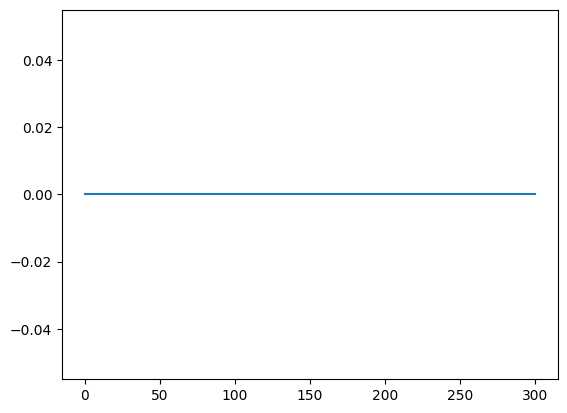

In [ ]:
plt.plot(e_k)

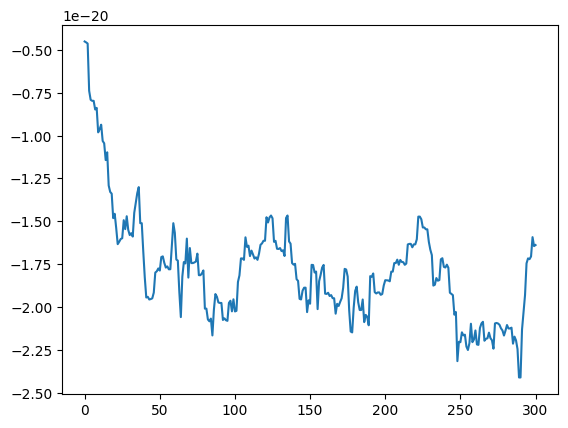

In [18]:
plt.plot(e_p)